# Model performance analysis

## Load data & models

In [1]:
import functions_model_analysis as f

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MultipleLocator
import scipy.stats as stats
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interpn

import sys
sys.path.append("../AWS_Scripts/")
import functions_model_analysis as ff

In [2]:
# date_from = "2019-08-14"
# date_to = "2019-08-14"

date_from = "2019-08-01"
date_to = "2019-08-20"

# date_from = "2019-08-02"
# date_to = "2019-08-02"

path = r"../Data/combined/dataframe_extended/"
data = f.import_data(date_from=date_from, date_to=date_to, df_path=path, predict_only=False)
data = f.data_normalization(data)
#data['opt_value2'] = (np.exp(data['opt_value'])-1)

100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


Not applicable for feature'mw_value'.
Not applicable for feature'col'.
Not applicable for feature'row'.
Not applicable for feature'mw_value_yesterday'.


In [11]:
LinReg = f.load_object('LinearRegression')
# LinReg_noXY = f.load_object('LinearRegression_NoXY')
# RigdeReg = f.load_object('RidgeRegression')
# LassoReg = f.load_object('LassoRegression')
# ElasticNetReg = f.load_object('ElasticNetRegression')
# RandomForest = f.load_object('RandomForest')
# GradientBoosting = f.load_object('XGBoost')

In [4]:
#model_list = [LassoReg , GradientBoosting, RandomForest] #, LassoReg, ElasticNetReg, RandomForest, GradientBoosting] # LinReg_noXY

### Predict

In [12]:
#lasso_pred = f.mean_predict(model=LassoReg, data=data)
#forest_pred = f.mean_predict(model=RandomForest, data=data)
#xgboost_pred = f.mean_predict(model=GradientBoosting, data=data)
LinReg_pred = f.mean_predict(LinReg, data = data)

In [10]:
# del xgboost_pred

## Analysis

### Model performance table

In [6]:
# model_list_all = [LinReg , LinReg_noXY, RigdeReg, LassoReg, ElasticNetReg, RandomForest, GradientBoosting]
# table = f.model_comparison_table(model_list_all).reset_index()
# table[table['Set']=='Test']

,Model,Set,RMSE,RMSE_std,R2,R2_std
1,LinearRegression,Test,0.184476,0.031713,0.048278,0.194516
3,LinearRegression_NoXY,Test,0.183465,0.024423,0.060173,0.129444
5,RidgeRegression,Test,0.184469,0.031698,0.048343,0.194484
7,LassoRegression,Test,0.179125,0.016700,0.100123,0.084724
9,ElasticNetRegression,Test,0.185035,0.028033,0.035457,0.208491
11,RandomForest,Test,0.197773,0.030502,-0.101216,0.246953
13,XGBoost,Test,0.188516,0.032070,-0.012913,0.300837


### Mean error plot (all models)


In [7]:
df_opt = (np.exp(data['opt_value'])-1)
bin_range = (df_opt.min(), df_opt.max())
bin_width = 0.1
bin_edges = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)
bin_labels = np.arange(0.05, bin_edges[-1]+0.05, 0.1)

# ORIGINAL

mean_error_list = []

for model in model_list:
    print(model.name)
    print('predict start')
    df = f.mean_predict(model, data)[['error_prediction']]
    print('predict done')
    df['value_bin'] = pd.cut(df_opt, bins=bin_edges, labels=False) 
    print('cut done')
    mean_error = df.groupby('value_bin')['error_prediction'].mean()
    print('group done')
    del df
    mean_error_list.append(mean_error)

LassoRegression
predict start
predict done
cut done
group done
XGBoost
predict start
predict done
cut done
group done
RandomForest
predict start
predict done
cut done
group done


In [ ]:
# doesnt work when gaps in buckets

# df = f.mean_predict(LinReg, data)[['error_prediction']]
# df['df_opt'] = df_opt
# df['value_bin'] = pd.cut(df_opt, bins=bin_edges, labels=False, include_lowest=True)
# bin_numbers = df['value_bin'].unique()
# mean_error = df.groupby('value_bin')['error_prediction'].mean()
# #del df
# #mean_error_list.append(mean_error)


# # # get bin numbers and see which dont overlap
# # # when plotting, interpolate
# # should_bin_numbers = list(range(0, len(bin_labels)))
# # missing_bins = list(set(should_bin_numbers) - set(bin_numbers))

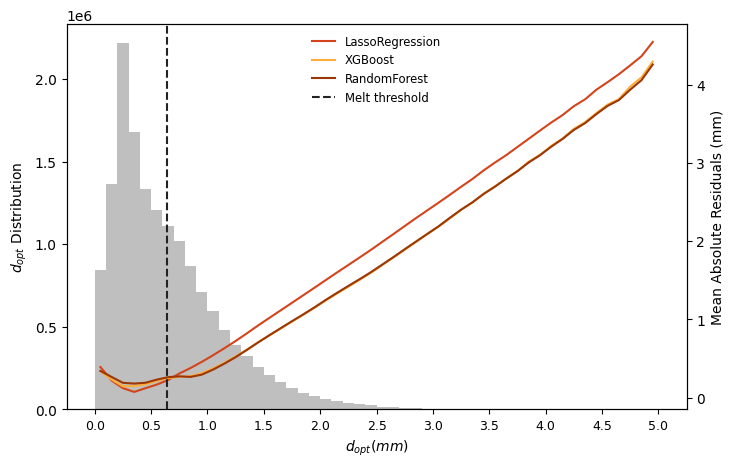

In [8]:
colors = ['#d4441c',  '#fead3a', '#9c3605']

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(df_opt, bins=bin_edges, color='gray', alpha=0.5)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.tick_params(axis = 'x', which = 'major', labelsize = 9)

ax2 = ax.twinx()
for i in range(len(mean_error_list)):
    ax2.plot(bin_labels, mean_error_list[i].values, label=model_list[i].name, color=colors[i])

ax2.axvline(x=0.64, color='#222222', linestyle='--', label = 'Melt threshold')
ax.set_xlabel('$d_{opt} (mm)$')
ax.set_ylabel('$d_{opt}$ Distribution')
ax2.set_ylabel('Mean Absolute Residuals (mm)')
#ax.set_title('$d_{opt}$ vs. Mean Absolute Residuals')
legend = ax2.legend(loc='upper center', fontsize='small')
legend.get_frame().set_alpha(0.0)
plt.show()

### Residual analysis

In [6]:
def residual_analysis(pred, data):
    sampled_df = pred.sample(frac=0.05, random_state=1)
    
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(3, 2, 2)
    ax3 = plt.subplot(3, 2, 4)
    ax4 = plt.subplot(3, 2, 6)

    axes = [ax1, ax2, ax3, ax4]

    #####################
    data1 = pred['residual_prediction']
    ax1.hist(data1, bins=100, color='grey')
    ax1.grid(color='lightgray')
    ax1.set_xlabel('Residual (mm)', fontsize = 9)
    ax1.set_ylabel('Frequency', fontsize = 9)
    ax1.set_title('a) Residual Distribution Histogram')

    #####################
    stats.probplot(data1, plot=ax2, fit=True) # Normality Q-Q Plot

    ax2.get_lines()[0].set_color('firebrick')
    ax2.get_lines()[1].set_color('#222222')
    ax2.set_xlabel('Theoretical Quantiles', fontsize = 9)
    ax2.set_ylabel('Data Sample Quantiles', fontsize = 9)
    ax2.set_title('b) Residual Distribution Normality Q-Q Plot') 
    #ax2.text(1.34, 0.98, "Residual Distribution Normality Q-Q Plot", fontsize=12, ha='center', va='top', transform=ax1.transAxes)

    #####################

    ax3.scatter(sampled_df['opt_value'], sampled_df['residual_prediction'], alpha=0.01, color='firebrick')
    ax3.axhline(y=0, color='lightgray', linewidth=0.5)

    ax3.set_xlabel('$d_{opt}$ (mm)', fontsize = 9)
    ax3.set_ylabel('Residual (mm)', fontsize = 9)
    #ax3.set_title('Sampled Data Scatter Plot', loc="left")
    ax3.text(1.25, 0.64, "c)", fontsize=12, ha='center', va='top', transform=ax1.transAxes)

    #####################

    ax4.scatter(sampled_df['mean_prediction'], sampled_df['residual_prediction'], alpha=0.01, color='firebrick')
    ax4.axhline(y=0, color='lightgray', linewidth=0.5)

    ax4.set_xlabel('$d_{opt}$ Predicted (mm)', fontsize = 9)
    ax4.set_ylabel('Residual (mm)',  fontsize = 9)
    ax4.text(1.25, 0.28, "d)", fontsize=12, ha='center', va='top', transform=ax1.transAxes)

    #####################


    #plt.suptitle("Residual analysis", fontsize=16)
    plt.show()



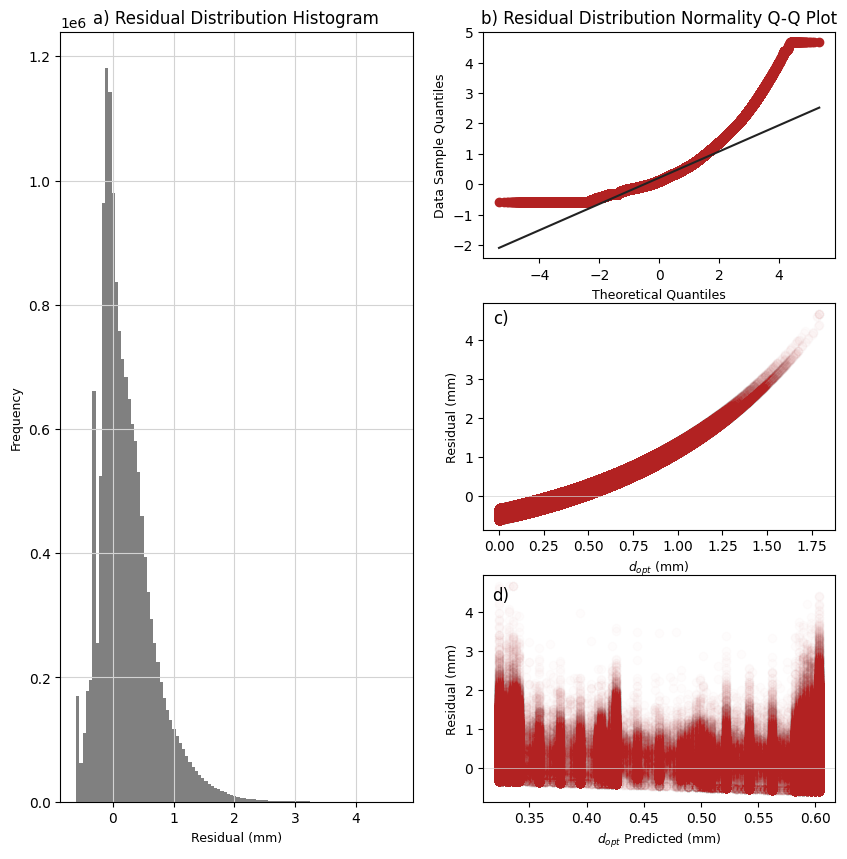

In [11]:
residual_analysis(lasso_pred, data) # done 20 days

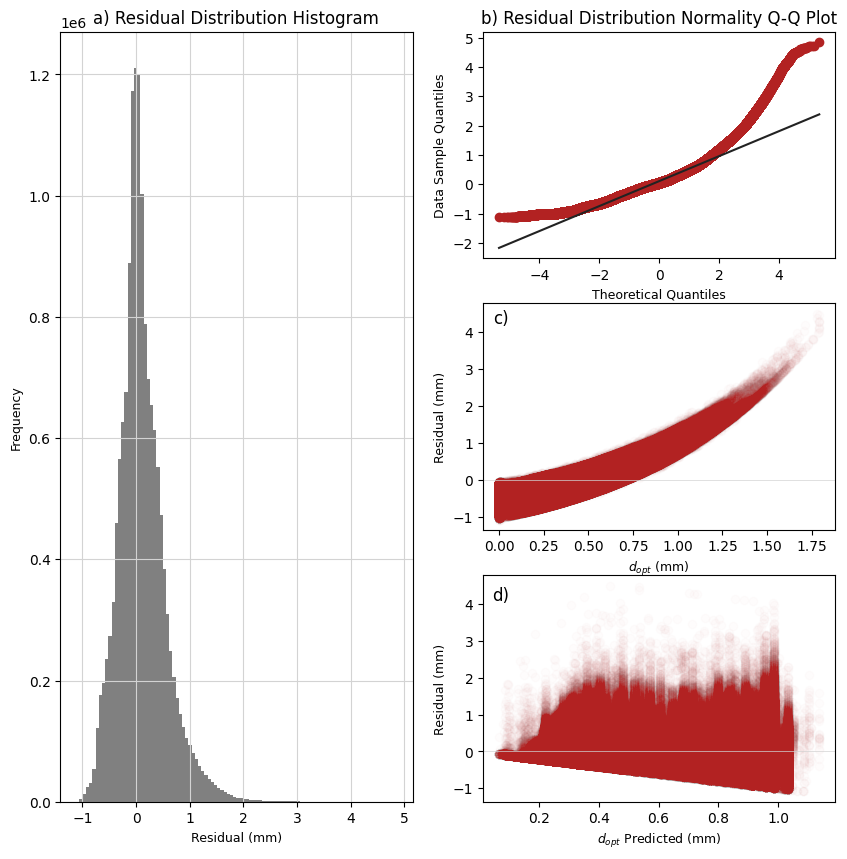

In [6]:
residual_analysis(forest_pred, data) # done 20 days

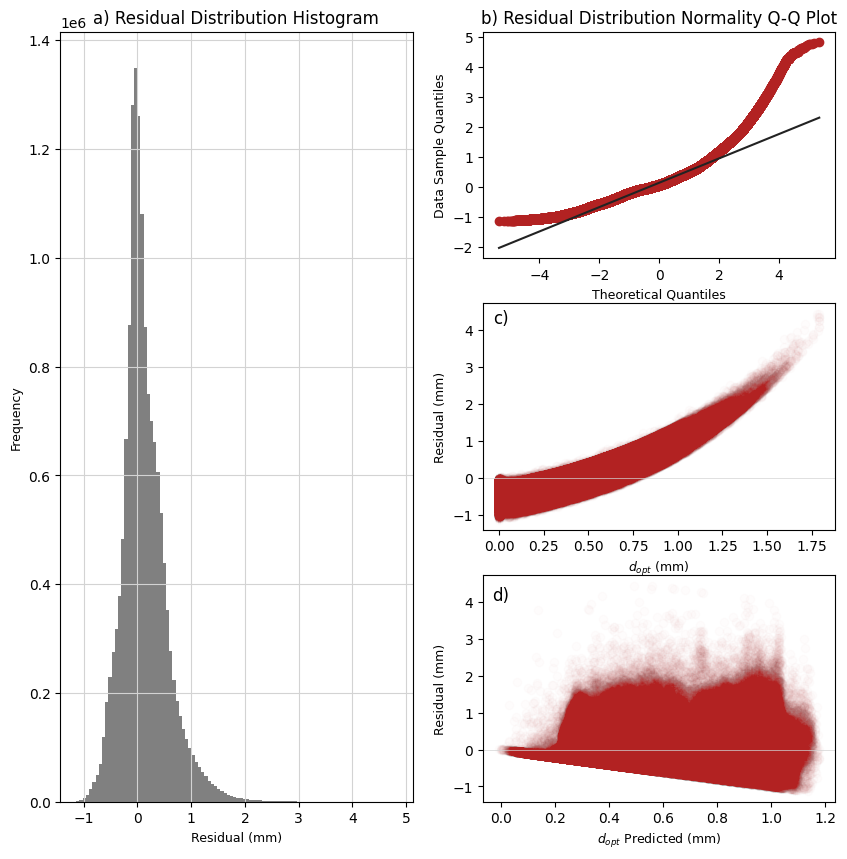

In [7]:
residual_analysis(xgboost_pred, data)

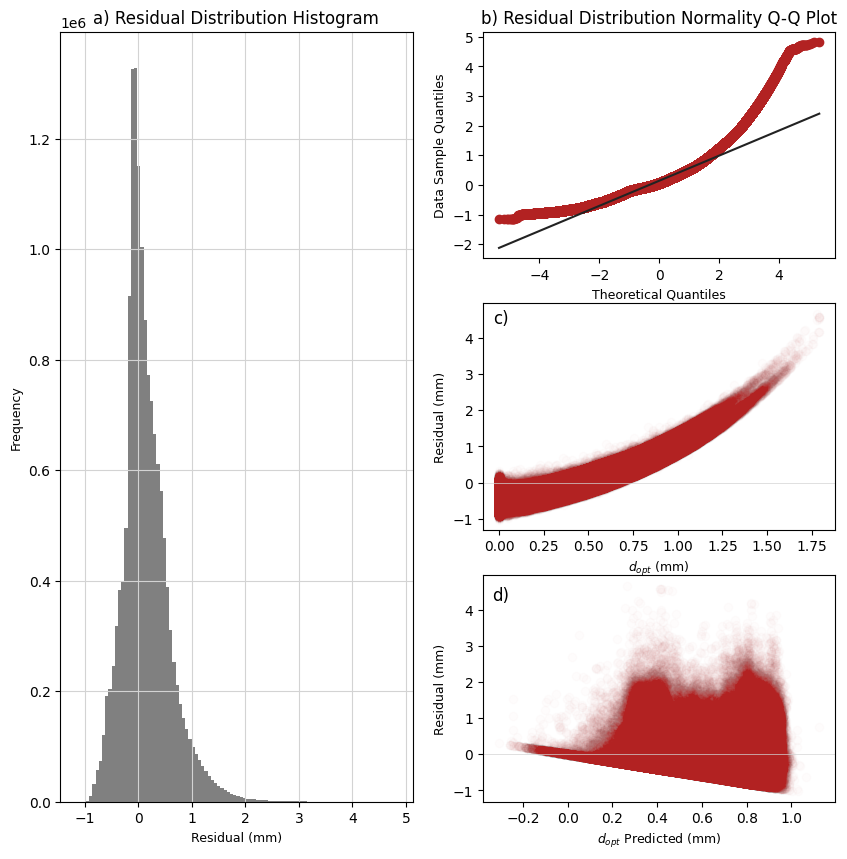

In [13]:
residual_analysis(LinReg_pred, data)

### Real vs predicted

In [8]:
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

def density_scatter(df, ax=None, sort=True, bins=20, bin_width=0.25, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    df = df.sample(frac=0.1, random_state=1)
    x=df['opt_value']
    y=df['mean_prediction']

    if ax is None:
        fig, ax = plt.subplots()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])), data, np.vstack([x, y]).T,
                method="splinef2d", bounds_error=False)
    #z[np.where(np.isnan(z))] = 0.0 # To be sure to plot all data

    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = np.argsort(z)
        x, y, z = np.array(x)[idx], np.array(y)[idx], np.array(z)[idx]

    sc = ax.scatter(x, y, c=z, cmap='YlOrBr_r', **kwargs)
    ax.set_xlabel('$d_{opt}$ (mm)')
    ax.set_ylabel('$d_{opt}$ Predicted (mm)')
    #ax.set_ylim(bottom = (y.min()-0.3))
    #ax.set_title('Real vs. Predicted Values')

    # Find the range of data
    data_min = min(x)
    data_max = max(y)

    # # Adding the line of exact match
    # lin = ax.plot([data_min, data_max], [data_min, data_max], color='black', linestyle='--')

    # Calculate average predicted value per bin of real value
    bin_edges = np.arange(min(x), max(x) + bin_width, bin_width)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    predicted_avg = [np.mean(y[(x >= bin_edges[i]) & (x < bin_edges[i + 1])]) for i in range(len(bin_centers))]

    # Plot line with average predicted value per bin
    line = ax.plot(bin_centers, predicted_avg, color='#222222', linestyle='--', linewidth=2, label='Average Predicted Value')

    # Colorbar and normalization
    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='YlOrBr_r'), ax=ax)
    cbar.ax.set_ylabel('Density')

    # Legend
    legend = ax.legend([line[0]], ['Average Predicted Value'], loc = 'lower right')
    #legend.get_frame().set_alpha(0.0)

    return ax


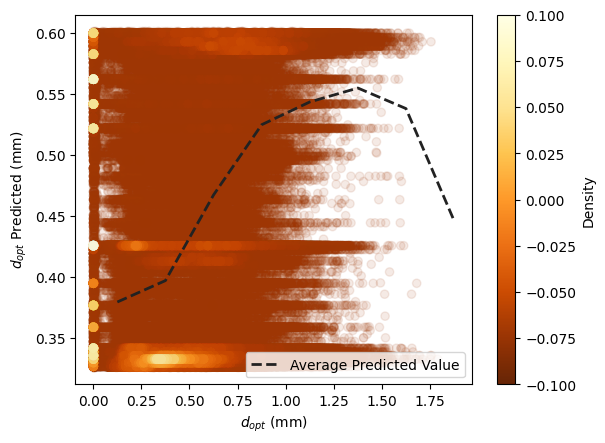

In [14]:
#for this plot need to uncomment the additional space!
density_scatter(lasso_pred, ax = None, sort = True, bins = 2000, alpha = 0.1); 

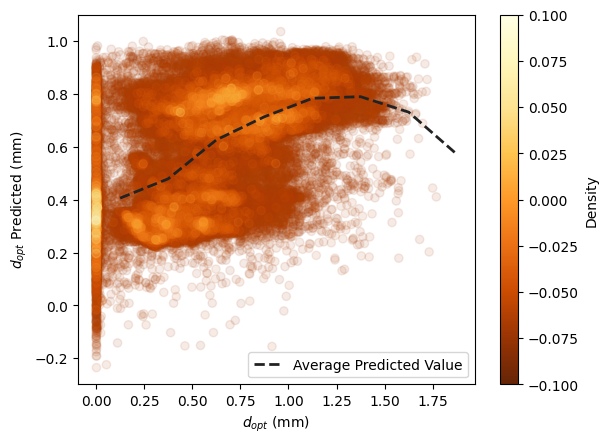

In [23]:
# lin_pred = f.mean_predict(LinReg, data)
# density_scatter(lin_pred, ax = None, sort = True, bins = 2000, alpha = 0.1); 

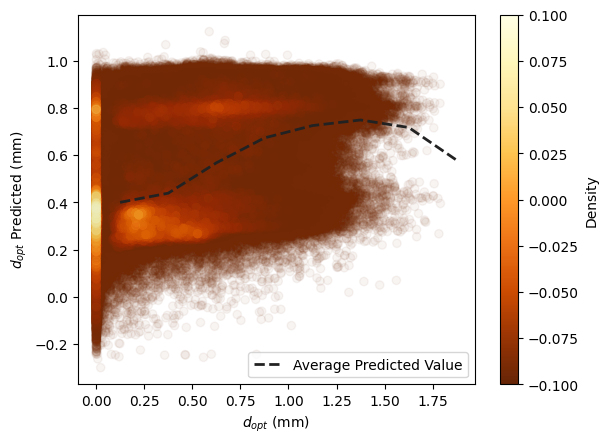

: 

In [14]:
density_scatter(LinReg_pred, ax = None, sort = True, bins = 2000, alpha = 0.05); 

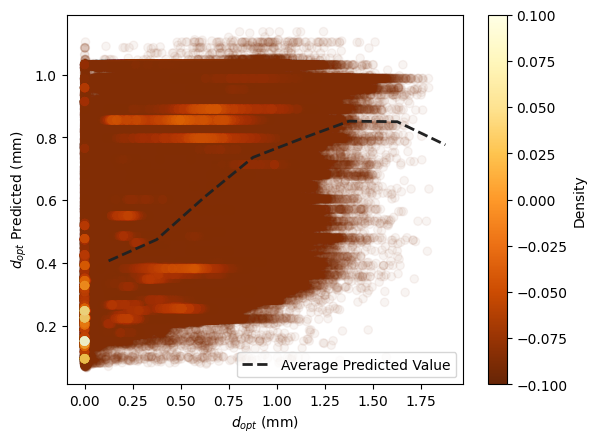

In [10]:
density_scatter(forest_pred, ax = None, sort = True, bins = 2000, alpha = 0.05); # done 20 days

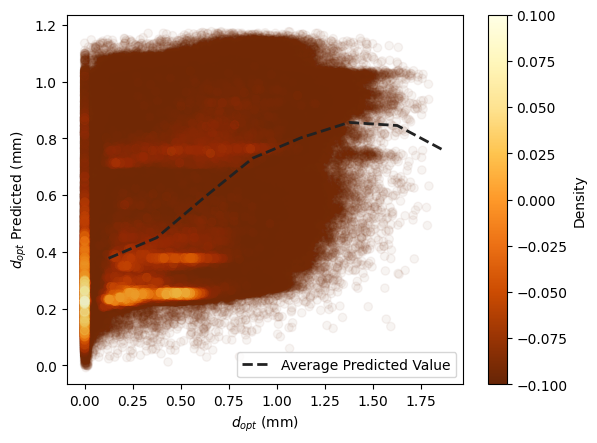

In [9]:
density_scatter(xgboost_pred, ax = None, sort = True, bins = 2000, alpha = 0.05); 

### Other plots

#### heat

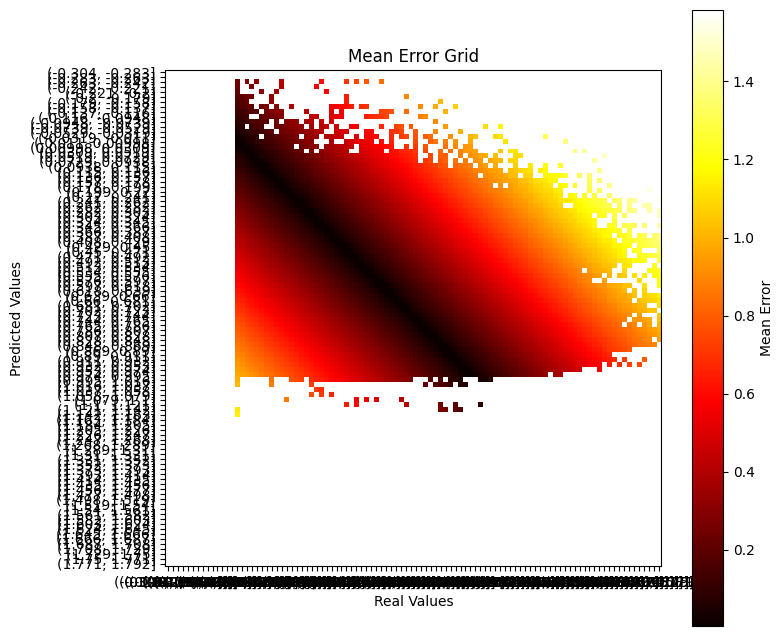

In [86]:
df = pred

# Define the number of bins
num_bins = 100

# Calculate the bin edges for real and predicted values
min_value = min(df['opt_value'].min(), df['mean_prediction'].min())
max_value = max(df['opt_value'].max(), df['mean_prediction'].max())
bin_edges = np.linspace(min_value, max_value, num=num_bins+1)

# Bin the real and predicted values using the same bin edges
real_bins = pd.cut(df['opt_value'], bins=bin_edges)
pred_bins = pd.cut(df['mean_prediction'], bins=bin_edges)

# Group the data by the bin ranges and calculate the mean error for each group
mean_error = df.groupby([real_bins, pred_bins])['error_prediction'].mean().unstack().T

# Create the heatmap grid
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(mean_error.values, cmap='hot')

# Set x and y axis labels
ax.set_xlabel('Real Values')
ax.set_ylabel('Predicted Values')

# Set x and y axis tick labels
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(mean_error.columns)
ax.set_yticklabels(mean_error.index)

# Set colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Mean Error')

# Show the plot
plt.title('Mean Error Grid')
plt.show()


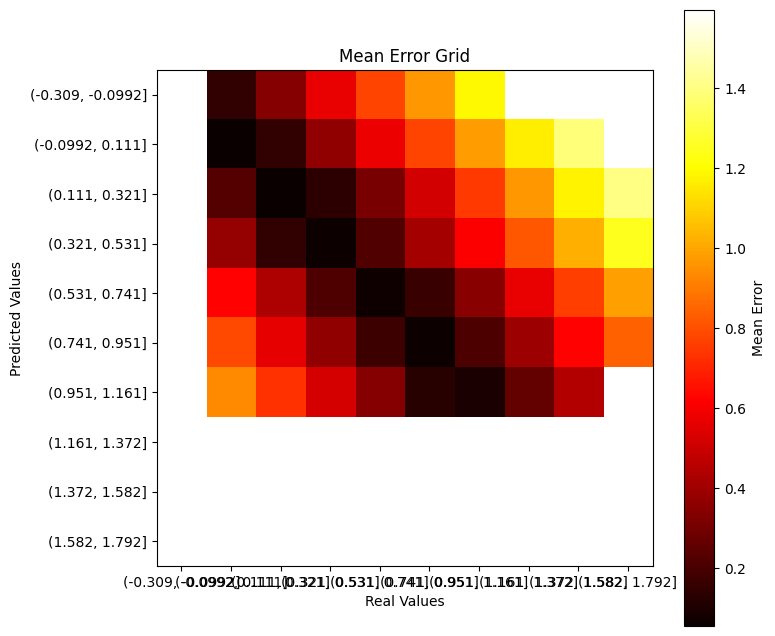

In [11]:
df = data_predicted

# Define the number of bins
num_bins = 10

# Calculate the bin edges for real and predicted values
min_value = min(df['opt_value'].min(), df['mean_prediction'].min())
max_value = max(df['opt_value'].max(), df['mean_prediction'].max())
bin_edges = np.linspace(min_value, max_value, num=num_bins+1)

# Bin the real and predicted values using the same bin edges
real_bins = pd.cut(df['opt_value'], bins=bin_edges)
pred_bins = pd.cut(df['mean_prediction'], bins=bin_edges)

# Group the data by the bin ranges and calculate the mean error for each group
mean_error = df.groupby([real_bins, pred_bins])['error_prediction'].mean().unstack().T

# Create the heatmap grid
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(mean_error.values, cmap='hot')

# Set x and y axis labels
ax.set_xlabel('Real Values')
ax.set_ylabel('Predicted Values')

# Set x and y axis tick labels
ax.set_xticks(np.arange(num_bins))
ax.set_yticks(np.arange(num_bins))
ax.set_xticklabels(mean_error.columns)
ax.set_yticklabels(mean_error.index)

# Set colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Mean Error')

# Show the plot
plt.title('Mean Error Grid')
plt.show()
